In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image_path = r"C:\Users\ghwns\HJ_git\CV-Projects\urban-scene-segmentation\Dataset\Cityspaces\images\train\aachen\aachen_000000_000019_leftImg8bit.png"
mask_path  = r"C:\Users\ghwns\HJ_git\CV-Projects\urban-scene-segmentation\Dataset\Cityspaces\gtFine\train\aachen\aachen_000000_000019_gtFine_color.png"

In [3]:
image = np.array(Image.open(image_path))         
mask  = np.array(Image.open(mask_path))         

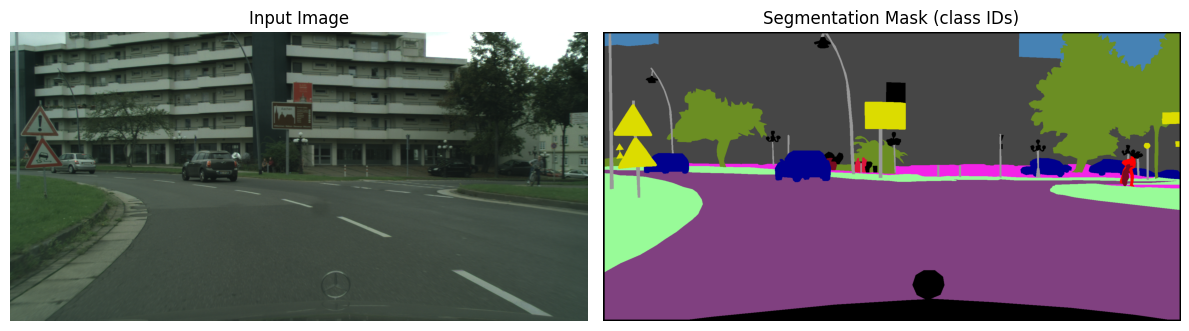

In [4]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Segmentation Mask (class IDs)")
plt.imshow(mask, cmap='nipy_spectral')  
plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
from torchvision import transforms

resize = transforms.Resize((256, 256))  
to_tensor = transforms.ToTensor()       

# 이미지 처리
image_resized = resize(Image.fromarray(image)) 
image_tensor = to_tensor(image_resized)

# 마스크 처리
mask_resized = resize(Image.fromarray(mask))
mask_tensor = np.array(mask_resized)           

In [6]:
print("Image:", image_tensor.shape, image_tensor.dtype)
print("Mask :", mask_tensor.shape, mask_tensor.dtype)    

Image: torch.Size([3, 256, 256]) torch.float32
Mask : (256, 256, 4) uint8


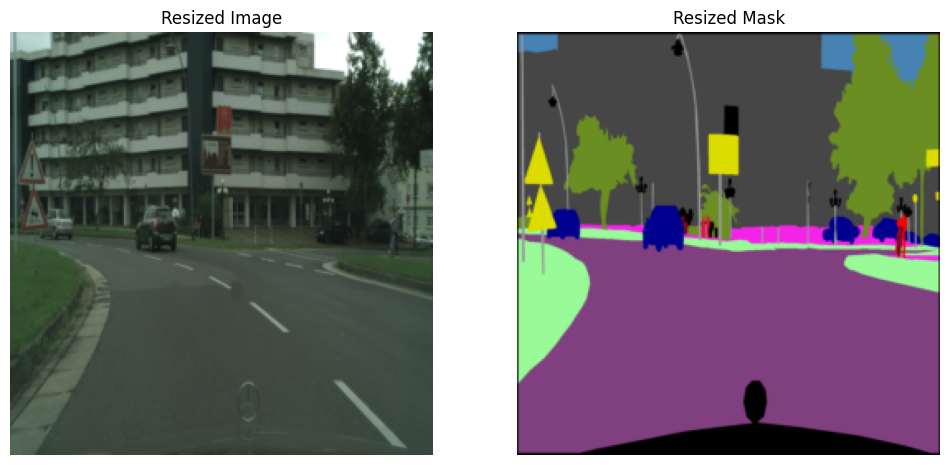

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Resized Image")
plt.imshow(image_tensor.permute(1, 2, 0))  
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Resized Mask")
plt.imshow(mask_tensor, cmap='nipy_spectral')
plt.axis('off')
plt.show()

In [8]:
import os
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch
from torchvision import transforms

class CityscapesDataset(Dataset):
    def __init__(self, image_dir, mask_dir, resize=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.resize = resize

      
        self.image_paths = []
        self.mask_paths = []

        for root, _, files in os.walk(image_dir):
            for file in files:
                if file.endswith("_leftImg8bit.png"):
                    image_path = os.path.join(root, file)

                    
                    mask_file = file.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                    mask_path = os.path.join(
                        mask_dir,
                        os.path.relpath(root, image_dir),  # 폴더 구조 유지
                        mask_file
                    )

                    self.image_paths.append(image_path)
                    self.mask_paths.append(mask_path)

        self.to_tensor = transforms.ToTensor()
        self.resize_img = transforms.Resize(resize)
        self.resize_mask = transforms.Resize(resize, interpolation=Image.NEAREST)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx])


        image = self.resize_img(image)
        mask = self.resize_mask(mask)

    
        image = self.to_tensor(image)  
        mask = torch.from_numpy(np.array(mask)).long()  

        return image, mask

In [9]:
dataset = CityscapesDataset(
    image_dir= r"C:\Users\ghwns\HJ_git\CV-Projects\urban-scene-segmentation\Dataset\Cityspaces\images\train",
    mask_dir= r"C:\Users\ghwns\HJ_git\CV-Projects\urban-scene-segmentation\Dataset\Cityspaces\gtFine\train",
    resize=(256, 256)
)

img, mask = dataset[0]

print("Image:", img.shape, img.dtype)   
print("Mask :", mask.shape, mask.dtype) 

Image: torch.Size([3, 256, 256]) torch.float32
Mask : torch.Size([256, 256]) torch.int64


In [10]:
from torch.utils.data import DataLoader

train_dataset = CityscapesDataset(
    image_dir="Dataset/Cityspaces/images/train",
    mask_dir="Dataset/Cityspaces/gtFine/train",
    resize=(256, 256)
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)

In [11]:
for images, masks in train_loader:
    print(images.shape, masks.shape)
    break

torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [12]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=34   
)


In [13]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 테스트 입력
x = torch.randn(1, 3, 256, 256).to(device)
out = model(x)
print(out.shape)


torch.Size([1, 34, 256, 256])


In [14]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [15]:
num_epochs = 5 

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device) 

    
        outputs = model(images)         
        loss = criterion(outputs, masks)  

 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}")

Epoch [1/5] - Loss: 982.9733
Epoch [2/5] - Loss: 490.0765
Epoch [3/5] - Loss: 412.0792
Epoch [4/5] - Loss: 365.1783
Epoch [5/5] - Loss: 331.2548


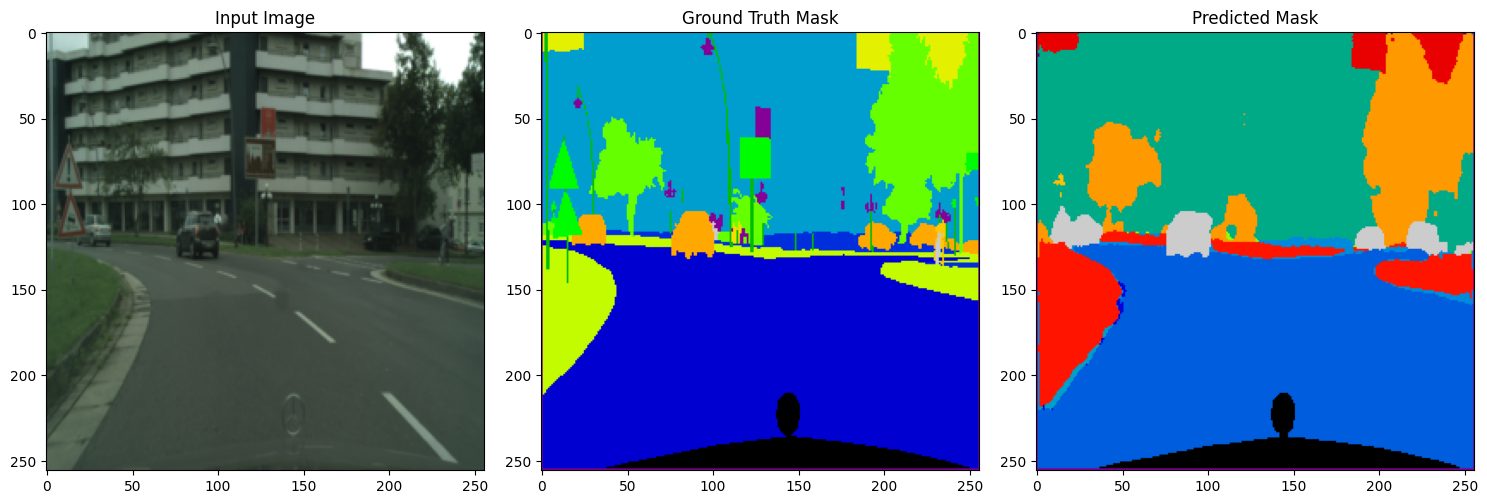

In [16]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    sample_img, sample_mask = train_dataset[0]  
    sample_img = sample_img.unsqueeze(0).to(device)  #

    output = model(sample_img)
    pred_mask = torch.argmax(output, dim=1)[0].cpu().numpy()

# 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(sample_img[0].cpu().permute(1, 2, 0))  

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(sample_mask, cmap='nipy_spectral')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap='nipy_spectral')

plt.tight_layout()
plt.show()
